In [1]:
from ocik.structure_learning.pc_undirected import pc_undirected
from ocik.example import Asia, Room
from ocik.causal_model import do_orientation
from ocik.home import iCasa
from graphviz import Digraph, Graph, Source
import numpy as np 
import pandas as pd
from scipy.stats import beta
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, K2Score

# Plot

In [2]:
def draw(edge, directed=True):
    dot = Digraph() if directed else Graph()
    dot.edges(edge)
    return dot

In [3]:
def difference(gt, pred):
    f = Digraph()
    new_edges = [ed for ed in pred if ed not in gt]
    f.attr('edge', color='blue')
    f.edges(new_edges)

    missed_edges = [ed for ed in gt if ed not in pred]
    f.attr('edge', color='red')
    f.edges(missed_edges)

    recovered_edges = [ed for ed in pred if ed in gt]
    f.attr('edge', color='green')
    f.edges(recovered_edges)
    return f

# Asia

## Ocik

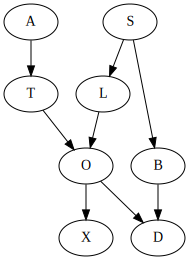

In [4]:
asia = Asia()
draw(asia.bn.G.edges())

In [5]:
df = asia.load_data(10000)
G = pc_undirected(df)
draw(G.edges(), directed=False)

edges = do_orientation(G.edges(), asia.bn)
difference(asia.bn.G.edges(), edges)

indépendance de niveau 0
indépendance de niveau 1


TypeError: do() got an unexpected keyword argument 'evidence'

## pgmpy

Working for n conditional variables: 3:  75%|███████▌  | 3/4 [00:00<00:00, 15.76it/s]


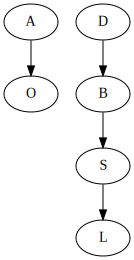

In [6]:
est = PC(data=df)
estimated_model = est.estimate(variant='stable', max_cond_vars=4)
draw(estimated_model.edges())
#difference(asia.bn.G.edges(), estimated_model.edges())

  0%|          | 6/10000 [00:00<13:51, 12.02it/s]


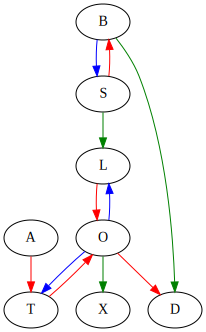

In [37]:
scoring_method = K2Score(data=df)
est = HillClimbSearch(data=df)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
difference(asia.bn.G.edges(), estimated_model.edges())

### pgmpy + ocik

  0%|          | 6/10000 [00:00<16:15, 10.24it/s]


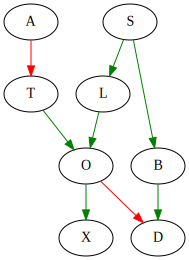

In [39]:
scoring_method = K2Score(data=df)
est = HillClimbSearch(data=df)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))

edges = do_orientation(estimated_model.edges(), asia.bn)
difference(asia.bn.G.edges(), edges)

# Room

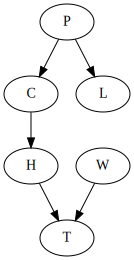

In [7]:
room = Room()
df = room.load_data(10000)
draw(room.bn.G.edges())

In [ ]:
def simulate(query_node: str, watch_nodes: list, env, do_size=100, same_seed=True):
    result = {}
    evidences = [{query_node: value} for value in [0, 1]]

    for i, evidence in enumerate(evidences):
        seed = 0 if same_seed else i
        do_result = env.do(evidence=evidence, size=do_size, seed=seed)

        ev = evidence[query_node]
        result[ev] = {}
        for node in watch_nodes:
            counts = do_result[node].value_counts()
            a = counts[0] + 1 if 0 in counts.index else 1
            b = counts[1] + 1 if 1 in counts.index else 1  # for a beta dist we need to add 1
            _, _, mod = beta_dist(a, b)
            result[ev][node] = mod

    return result

In [9]:
room.bn.do_envidence(evidence={"P":1})['']

,C,H,L,P,T,W
0,1,1,1,1,1,1
1,1,0,0,1,0,0
2,0,0,1,1,1,1
3,1,0,1,1,0,0
4,1,1,1,1,1,0
...,...,...,...,...,...,...
95,0,1,1,1,1,0
96,1,1,1,1,1,1
97,0,1,1,1,1,1
98,1,1,1,1,1,0


indépendance de niveau 0
indépendance de niveau 1


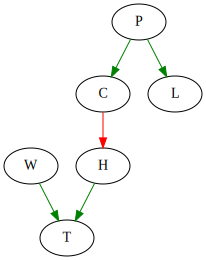

In [43]:
G = pc_undirected(df)
draw(G.edges(), directed=False)

edges = do_orientation(G.edges(), room.bn)
difference(room.bn.G.edges(), edges)

## pgmpy

Working for n conditional variables: 3:  75%|███████▌  | 3/4 [00:00<00:00, 26.37it/s]


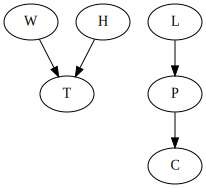

In [23]:
est = PC(data=df)
estimated_model = est.estimate(variant='stable', max_cond_vars=4)
draw(estimated_model.edges())

  0%|          | 5/10000 [00:00<10:02, 16.58it/s]


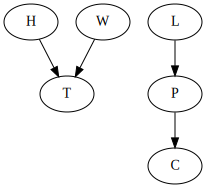

In [24]:
scoring_method = K2Score(data=df)
est = HillClimbSearch(data=df)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
draw(estimated_model.edges())

# iCasa

In [44]:
df = pd.read_csv('ocik/demo/store/icasa_.csv')
df = df[df['window__blinds_open']!=-1]

In [45]:
df

,out_thermometer__etienne.temperature,heater__heater.powerLevel,thermometer__etienne.temperature,window__window.opened,window__blinds_open
0,28,0.0,27.999980,True,0
1,23,0.0,23.000007,True,0
2,0,1.0,0.400031,True,1
3,7,1.0,7.399990,True,1
4,0,1.0,0.400010,True,1
...,...,...,...,...,...
995,28,0.0,21.609859,False,0
996,28,0.0,23.062687,False,0
997,23,0.0,23.081315,False,0
998,0,1.0,0.400032,True,1


In [46]:
df['thermometer__etienne.temperature'] = (df['thermometer__etienne.temperature']>19)*1
df['out_thermometer__etienne.temperature'] = (df['out_thermometer__etienne.temperature']>19)*1
df['window__window.opened'] = df['window__window.opened']*1
df['window__blinds_open'] = abs(df['window__blinds_open'])
df['heater__heater.powerLevel'] = (df['heater__heater.powerLevel']>0.5)*1

In [47]:
df

,out_thermometer__etienne.temperature,heater__heater.powerLevel,thermometer__etienne.temperature,window__window.opened,window__blinds_open
0,1,0,1,1,0
1,1,0,1,1,0
2,0,1,0,1,1
3,0,1,0,1,1
4,0,1,0,1,1
...,...,...,...,...,...
995,1,0,1,0,0
996,1,0,1,0,0
997,1,0,1,0,0
998,0,1,0,1,1


In [48]:
for col in df:
    print(col, df[col].unique())

out_thermometer__etienne.temperature [1 0]
heater__heater.powerLevel [0 1]
thermometer__etienne.temperature [1 0]
window__window.opened [1 0]
window__blinds_open [0 1]


indépendance de niveau 0
out_thermometer__etienne.temperature ⟂ window__window.opened | []
window__window.opened ⟂ out_thermometer__etienne.temperature | []
indépendance de niveau 1
out_thermometer__etienne.temperature ⟂ thermometer__etienne.temperature | ['window__blinds_open']
thermometer__etienne.temperature ⟂ heater__heater.powerLevel | ['window__blinds_open']
thermometer__etienne.temperature ⟂ out_thermometer__etienne.temperature | ['window__blinds_open']
heater__heater.powerLevel ⟂ thermometer__etienne.temperature | ['window__blinds_open']
indépendance de niveau 2
window__blinds_open ⟂ window__window.opened | ['out_thermometer__etienne.temperature', 'thermometer__etienne.temperature']


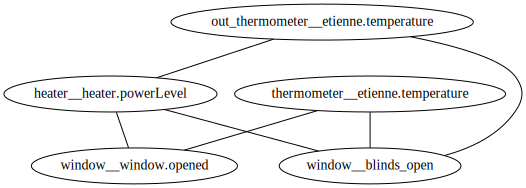

In [49]:
G = pc_undirected(df, verbose=True)
draw(G.edges(), directed=False)

## pgmpy

Working for n conditional variables: 4: 100%|██████████| 4/4 [00:00<00:00, 13.97it/s]/Users/kanva/anaconda3/envs/projetia/lib/python3.8/site-packages/pgmpy/estimators/PC.py:366: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 4: 100%|██████████| 4/4 [00:00<00:00, 22.46it/s]
/Users/kanva/anaconda3/envs/projetia/lib/python3.8/site-packages/pgmpy/base/DAG.py:885: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


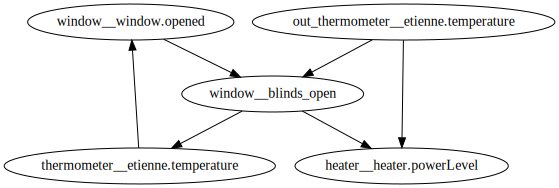

In [31]:
est = PC(data=df)
estimated_model = est.estimate(variant='stable', max_cond_vars=4)
draw(estimated_model.edges())

  0%|          | 8/10000 [00:00<05:39, 29.45it/s]


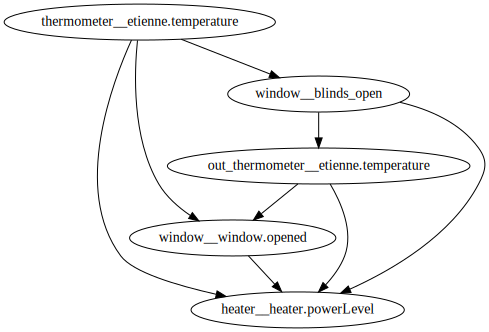

In [32]:
scoring_method = K2Score(data=df)
est = HillClimbSearch(data=df)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
draw(estimated_model.edges())

In [41]:
home = iCasa()

In [ ]:
simulate("window__window.opened", ['thermometer__etienne.temperature'], home)

In [86]:
import pandas as pd
import json
import requests
from requests.auth import HTTPBasicAuth
from time import sleep
import numpy as np
from tqdm import tqdm


class iCasa:
    __auth = HTTPBasicAuth('reader', 'xai')

    __get_device_url = 'https://explainableai.fr/icasaSimulation/icasa/devices/devices'
    __get_zone_url = 'https://explainableai.fr/icasaSimulation/icasa/zones/zones'

    __put_device_url = 'https://explainableai.fr/icasaSimulation/etienne/device/autonomic/device/'
    __put_zone_url = 'https://explainableai.fr/icasaSimulation/etienne/zones/'

    def __init__(self):
        # self.set_devices = {"temperature_controller": "m_target_temperature",
        #                     'window': 'm_open',
        #                     'window': 'm_blinds_open',
        #                     'heater': 'm_heater.powerLevel'}
        #
        # self.set_zones = {'outdoor': 'myTemperature'}

        self.read_devices = {"heater": ['heater.powerLevel', 'm_heater.powerLevel'],
                             "thermometer": ['etienne.temperature'],
                             "out_thermometer": ['etienne.temperature'],
                             'window': ['blinds_open', 'window.opened', 'm_open', 'm_blinds_open'],
                             "temperature_controller": ['m_target_temperature'],
                             }
        self.data = None
        
        self.controlable = ['window__m_open', 'window__m_blinds_open'] \
                           + ["heater__m_heater.powerLevel", "out_thermometer__etienne.temperature"]
        
        self.action_node = {'window__window.opened':('window', 'm_open'),
                            'window__blinds_open':('window', 'blinds_open'),
                            'heater__heater.powerLevel':('heater', 'm_heater.powerLevel'),
                            'out_thermometer__etienne.temperature': ('outdoor', 'myTemperature')}

        self.name2kind = {'outdoor': 'zone', 'window': 'device', 'out_thermometer': 'device',
                          'heater': 'device', 'temperature_controller': 'device'}

        self.name = lambda k, p, v: (self.name2kind[k], (k, p), float(v))

        self.state = [('window', 'm_open'), ('window', 'm_blinds_open'), ('heater', 'm_heater.powerLevel')]
        self.temperature = [0, 7, 17, 23, 28, 30]
        self.reset_auto()
        self._do([self.name('temperature_controller', 'm_target_temperature', 20)], resp_time=0)

    def fetch_data(self) -> pd.DataFrame:
        new_data = {}

        # Read sensor data
        resp_device = requests.get(self.__get_device_url, auth=self.__auth)
        if resp_device.status_code != 200:
            print("data loading fail!")

        for device in resp_device.json():
            id = device['id']
            if id not in self.read_devices: continue
            for param in device['properties']:
                if param['name'] in self.read_devices[id]:
                    new_data[id + '__' + param['name']] = [param['value']]

        # read state

        # update with new sensor data
        return pd.DataFrame(new_data)

    def add_record(self) -> pd.DataFrame:
        new_data = self.fetch_data()
        if self.data is None:
            self.data = new_data
        else:
            self.data = pd.concat((self.data, new_data))
        return self.data

    def reset_auto(self):
        T = np.random.choice(self.temperature)
        print('reset T to:', T)
        to_do = [(self.name(remain[0], remain[1], -1)) for remain in self.state] \
                + [('zone', ('outdoor', 'myTemperature'), float(T))]
        self._do(to_do, resp_time=0)

    def _do(self, evidence, resp_time=0, verbose=False) -> pd.DataFrame:
        """
        evidence: list of (kind, name, val)
        resp_time : (in sec) waiting time before fetching data
        """
        for kind, (name, property), value in evidence:
            if kind == 'device':
                resp = requests.put(self.__put_device_url + f'/{name}',
                                    data=json.dumps({'id': name, property: value}),
                                    auth=self.__auth)
            elif kind == 'zone':
                resp = requests.put(self.__put_zone_url + f'/{name}',
                                    data=json.dumps({property: value}),
                                    auth=self.__auth)
            else:
                assert False, 'not recongnize option: kind'

            if resp.status_code != 200:
                print("pushing data fail!")

        print('waiting for response...', end='') if verbose else None
        sleep(resp_time) if resp_time > 0 else None
        print('[OK]') if verbose else None

        return self.fetch_data()

    def do(self, evidence, size=1, seed=12, resp_time=3, verbose=True):
        np.random.seed(seed)
        self.reset_auto()
        
        if evidence is None:
            evidence = {}

        # reformat evidence
        evidence_ = [self.name(*self.action_node[k], v) for k, v in evidence.items()]

        column = [f'{k}__{v[0]}' for k, v in self.read_devices.items()]
        df = pd.DataFrame({node: [] for node in column}).astype(int)
        for i in range(size):
            df = pd.concat((df, self._do(evidence_, resp_time=resp_time, verbose=True)))
            self.reset_auto()

        df.reset_index(drop=True, inplace=True)
        return df

In [87]:
home = iCasa()

reset T to: 30


In [88]:
home.do({"window__window.opened":1}, 1)

reset T to: 23
waiting for response...[OK]
reset T to: 23


,heater__heater.powerLevel,thermometer__etienne.temperature,out_thermometer__etienne.temperature,window__blinds_open,temperature_controller__m_target_temperature,heater__m_heater.powerLevel,window__window.opened,window__m_open,window__m_blinds_open
0,0,23.0,23,0,20,-1.0,True,1.0,-1.0


In [72]:
home.do({"window__window.opened":0})

waiting for response...[OK]


,heater__heater.powerLevel,thermometer__etienne.temperature,out_thermometer__etienne.temperature,window__blinds_open,temperature_controller__m_target_temperature,heater__m_heater.powerLevel,window__window.opened,window__m_open,window__m_blinds_open
0,0,23.0,23,-1,20,-1.0,False,0.0,-1


In [70]:
home.fetch_data()

,out_thermometer__etienne.temperature,heater__m_heater.powerLevel,heater__heater.powerLevel,temperature_controller__m_target_temperature,thermometer__etienne.temperature,window__window.opened,window__m_open,window__m_blinds_open,window__blinds_open
0,23,-1,0,20,23.0,True,-1,-1,-1
